In [40]:
import bayeux as bx
import bambi as bmb
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from formulae import design_matrices

In [3]:
def forrester_fn(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

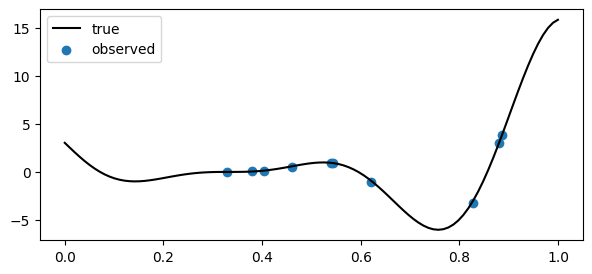

In [226]:
# observe a noisy version of the function
size = 10

x_ = np.random.rand(size)
y_ = forrester_fn(x_) + np.random.randn(size) * 0.1

xs = np.linspace(0, 1, 100)
ys = forrester_fn(x)

data = pd.DataFrame({'x': x_, 'y': y_})

plt.figure(figsize=(7, 3))
plt.plot(xs, ys, label='true', color='black')
plt.scatter(x_, y_, label='observed')
plt.legend();

In [182]:
knots = np.quantile(x_, np.linspace(0, 1, 5))
iknots = knots[1:-1]
iknots

array([0.41777759, 0.53922514, 0.66759265])

In [183]:
model = bmb.Model("y ~ bs(x, knots=iknots, intercept=True)", data=data)
model.build()
bx_model = bx.Model.from_pymc(model.backend.model)
idata = bx_model.mcmc.numpyro_nuts(seed=jax.random.key(0))

sample: 100%|██████████| 1500/1500 [00:04<00:00, 325.42it/s]


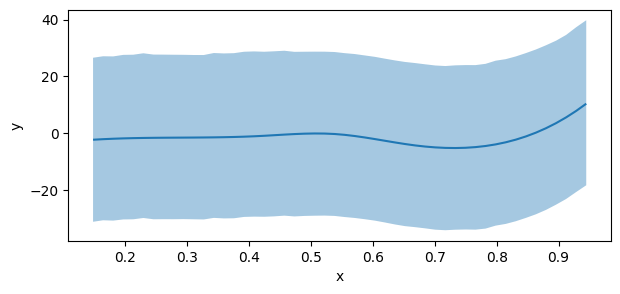

In [184]:
bmb.interpret.plot_predictions(
    model,
    idata,
    "x",
    pps=False,
    # prob=0.5,
    fig_kwargs={"figsize": (7, 3)}
);

In [185]:
pps = model.predict(idata, kind="pps", inplace=False)
pps["posterior_predictive"].mean(("chain", "draw"))["y"]

<xarray.DataArray 'y' (y_obs: 10)> Size: 80B
array([-0.13012349, -1.29194732, -0.2244082 , 10.35444665,  3.15422198,
       -4.56784514, -3.3951141 , -0.48184384, -1.6126459 , -2.33673601])
Coordinates:
  * y_obs    (y_obs) int64 80B 0 1 2 3 4 5 6 7 8 9

In [188]:
data["pps"] = pps["posterior_predictive"].mean(("chain", "draw"))["y"]
data["lower"] = pps["posterior_predictive"].quantile(0.025, dim=("chain", "draw"))["y"]
data["upper"] = pps["posterior_predictive"].quantile(0.975, dim=("chain", "draw"))["y"]
data.sort_values("x", inplace=True)

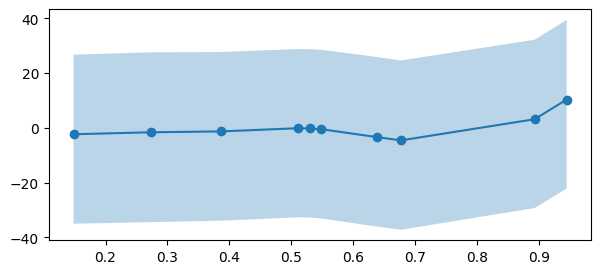

In [189]:
plt.figure(figsize=(7, 3))
plt.plot(
    data["x"],
    data["pps"],
    marker="o",
)
plt.fill_between(data["x"], data["lower"], data["upper"], alpha=0.3);

In [190]:
mu = pps["posterior_predictive"].mean(("chain", "draw"))["y"].to_numpy()
std = pps["posterior_predictive"].std(("chain", "draw"))["y"].to_numpy()

In [191]:
import scipy.stats as stats

In [214]:
def probability_of_improvement(mu, sigma, f_star):
    """
    Calculate the Probability of Improvement (PI) policy.

    Parameters:
        mu (float): Mean predicted value at point x.
        sigma (float): Standard deviation of predicted values at point x.
        f_star (float): Current best observed value.

    Returns:
        float: Probability of Improvement at point x.
    """
    z = (mu - f_star) / sigma
    pi = stats.norm.cdf(z)
    # pi = stats.norm(mu, sigma)
    # pi = 1 - pi.cdf(f_star)
    return pi

In [192]:
# Randomly select a candidate point
candidate = np.array([0.7])

pps_candidate = model.predict(idata, kind="pps", inplace=False, data=pd.DataFrame({"x": candidate}))
candidate_mu = pps_candidate["posterior_predictive"].mean(("chain", "draw"))["y"].to_numpy()
candidate_std = pps_candidate["posterior_predictive"].std(("chain", "draw"))["y"].to_numpy()

dist = stats.norm(candidate_mu, candidate_std)

# Initialize a normal distribution with mu and std
best_x = x_[np.argmin(y_)]
best_y = np.min(y_)

poi = 1 - dist.cdf(best_y)

In [193]:
best_x, best_y

(0.6771143998332181, -3.5374086988340805)

In [194]:
candidate, candidate_mu, candidate_std, poi

(array([0.7]), array([-5.01622191]), array([15.62009544]), array([0.46228698]))

In [215]:
xs = np.linspace(0, 1, 100)

pps = model.predict(idata, kind="pps", inplace=False, data=pd.DataFrame({"x": xs}))
mus = pps["posterior_predictive"].mean(("chain", "draw"))["y"].to_numpy()
stds = pps["posterior_predictive"].std(("chain", "draw"))["y"].to_numpy()

poi = probability_of_improvement(mus, stds, best_y)

In [232]:
data

,x,y
0,0.461007,0.540157
1,0.826824,-3.202504
2,0.539118,0.960787
3,0.887265,3.816174
4,0.880107,3.053404
5,0.328303,-0.031790
6,0.404425,0.069002
7,0.544647,0.954149
8,0.621693,-1.094474
9,0.379356,0.056790


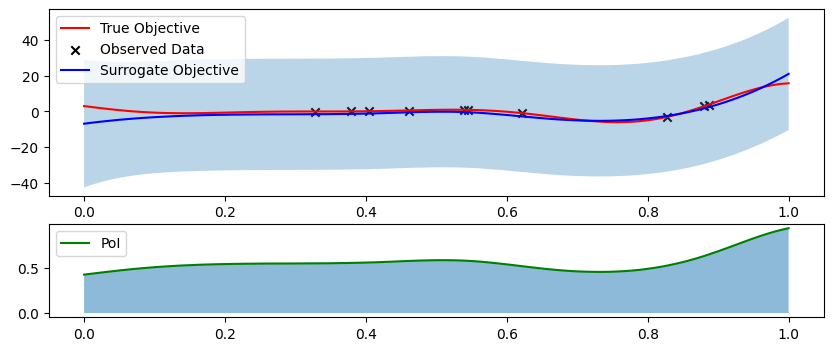

In [243]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, 
    gridspec_kw={"height_ratios": [2, 1]}, 
    figsize=(10, 4)
)

ax[0].plot(xs, ys, color="red", label="True Objective")
ax[0].scatter(data["x"], data["y"], marker="x", color="black", label="Observed Data")
ax[0].plot(xs, mus, color="blue", label="Surrogate Objective")
ax[0].fill_between(xs, mus - 2 * stds, mus + 2 * stds, alpha=0.3)
ax[0].legend()

ax[1].plot(xs, poi, color="green", label="PoI")
ax[1].fill_between(xs, poi, 0, alpha=0.5)
ax[1].legend();

In [ ]:
for i in range(10):

    # Fit the model
    model = bmb.Model("y ~ bs(x, knots=iknots, intercept=True)", data=data)
    model.build()
    bx_model = bx.Model.from_pymc(model.backend.model)
    idata = bx_model.mcmc.numpyro_nuts(seed=jax.random.key(0))

    # Current incumbent
    best_x = x_[np.argmin(y_)]
    best_y = np.min(y_) 

    # Define the policy
    